First, lets reconstruct dimuon z mass.
reaplying previous code. Using the following criteria to select two well-defined and isolated muons.

In [259]:
import uproot
import matplotlib.pyplot as plt
import numpy as np
import awkward as ak
import uproot_methods
from scipy.optimize import curve_fit

In [173]:
file=uproot.open('~/Downloads/DYJetsToMuMu_M-50_TuneCP5_14TeV-madgraphMLM-pythia8.root')['Events']
muon=file.arrays(['Muon_pt','Muon_eta','Muon_phi','Muon_mass',
                  'Muon_charge','Muon_isGlobal','Muon_genPartIdx',
                  'GenPart_pt', 'GenPart_eta', 'GenPart_phi', 
                  'GenPart_mass'], namedecode='utf-8')

In [152]:
gen=file.arrays(['GenPart_pt', 'GenPart_eta', 'GenPart_phi', 'GenPart_mass'], namedecode='utf-8')

In [279]:
muons=ak.JaggedArray.zip(pt=muon['Muon_pt'], eta=muon['Muon_eta'], 
                         phi=muon['Muon_phi'], mass=muon['Muon_mass'], 
                         charge=muon['Muon_charge'], genidx=muon['Muon_genPartIdx'] )
gens=ak.JaggedArray.zip(pt=muon['GenPart_pt'], eta=muon['GenPart_eta'],
                              phi=muon['GenPart_phi'], mass=muon['GenPart_mass'],)

In [280]:
#muons_table=awkward.Table(muons)

In [281]:
#print(muons[:2])

In [282]:
#muon_table=awkward.Table(muon)

In [283]:
#gen_table=awkward.Table(gen)

In [284]:
muon_mask=(muon['Muon_genPartIdx']!=-1)& (muon['Muon_isGlobal']==1)& (muon['Muon_pt']>20)& (abs(muon['Muon_eta'])<2.4)

In [285]:
#muon_mask

In [286]:
muons_good=muons[muon_mask]

In [287]:
#type(muon_table)

In [288]:
#muon_mask.sum()

In [289]:
(muon_mask.sum()==2).sum()

57174

In [290]:
(muon_mask.sum()==3).sum()

27

In [291]:
(muon_mask.sum()==1).sum()

42958

Note here if we write a for loop, then 42958 events are don't woth to loop over it. By using columnar method, time is saved.

In [292]:
(muon_mask.sum()==4).sum()

1

In [293]:
(muon_mask.sum()==5).sum()

0

In [294]:
(muon_mask.sum()==6).sum()

0

In [295]:
two_good_muons=muons_good[muon_mask.sum()==2]

#two_muon_table=muon_table[muon_mask.sum()==2]
#two_muon_mask=muon_mask[muon_mask.sum()==2]

In [301]:
two_good_muons.charge

<JaggedArray [[1 -1] [1 -1] [1 -1] ... [-1 1] [-1 1] [-1 1]] at 0x7fdd9c8a0310>

Lets make sure muons in eaach events have opposite charge

In [304]:
opposite_sign_muon_mask=(two_good_muons.charge[:,0]!=two_good_muons.charge[:,1])

In [305]:
two_opposite_good_muons=two_good_muons[opposite_sign_muon_mask]
opposite_sign_muon_mask.sum()

57165

<JaggedArray [[True True False] [True True] [True True] ... [True True] [True True] [True True False]] at 0x7fddac5df590>

In [192]:
mup_mum_table=two_muon_table[opposite_sign_muon_mask]

In [306]:
two_muon_p4=uproot_methods.TLorentzVectorArray.from_ptetaphim(two_opposite_good_muons.pt, two_opposite_good_muons.eta,
                                                              two_opposite_good_muons.phi, two_opposite_good_muons.mass)

In [307]:
dimuon_p4=two_muon_p4[:,0]+two_muon_p4[:,1]
#dimuon_p4.mass

Text(0, 0.5, 'Events')

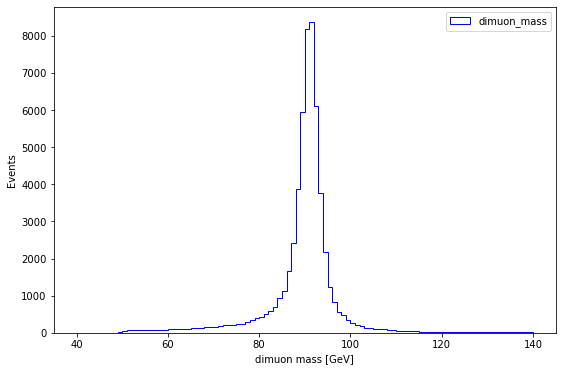

In [308]:
plt.figure(figsize=(9,6))
plt.hist(dimuon_p4.mass, bins=100, range=[40,140], histtype='step', color='blue', label='dimuon_mass')
plt.legend()
plt.xlabel('dimuon mass [GeV]')
plt.ylabel('Events')

Now lets get their corresponding genpart and gen dimuon mass.

In [312]:
idx=two_opposite_good_muons.genidx
pf_gen_muons=((gens[muon_mask.sum()==2])[opposite_sign_muon_mask])[idx]

In [313]:
two_gen_muon_p4=uproot_methods.TLorentzVectorArray.from_ptetaphim(pf_gen_muons.pt, pf_gen_muons.eta,
                                                                  pf_gen_muons.phi, pf_gen_muons.mass)

In [314]:
gen_dimuon_p4=two_gen_muon_p4[:,0]+two_gen_muon_p4[:,1]

Text(0, 0.5, 'Events')

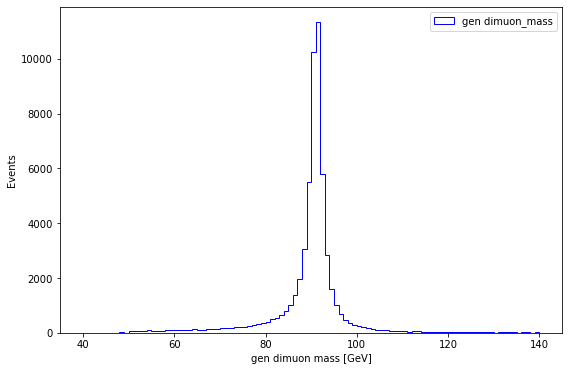

In [315]:
plt.figure(figsize=(9,6))
n=plt.hist(gen_dimuon_p4.mass, bins=100, range=[40,140], histtype='step', color='blue', label='gen dimuon_mass')
plt.legend()
plt.xlabel('gen dimuon mass [GeV]')
plt.ylabel('Events')

In [209]:
n

(array([0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 2.0000e+00,
        2.0000e+00, 4.0000e+00, 2.0000e+00, 1.1000e+01, 7.0000e+00,
        6.6000e+01, 7.1000e+01, 7.6000e+01, 7.2000e+01, 8.8000e+01,
        7.8000e+01, 6.6000e+01, 7.9000e+01, 9.4000e+01, 8.7000e+01,
        1.1400e+02, 9.4000e+01, 9.3000e+01, 1.1300e+02, 1.2200e+02,
        1.1600e+02, 1.1800e+02, 1.3600e+02, 1.4100e+02, 1.5300e+02,
        1.6400e+02, 1.6800e+02, 1.8600e+02, 2.0600e+02, 2.1000e+02,
        2.0600e+02, 2.3800e+02, 2.9400e+02, 3.1600e+02, 3.4900e+02,
        4.0100e+02, 4.8600e+02, 5.3700e+02, 6.3700e+02, 7.9200e+02,
        1.0010e+03, 1.3740e+03, 1.9470e+03, 3.0710e+03, 5.4970e+03,
        1.0240e+04, 1.1339e+04, 5.8100e+03, 2.8580e+03, 1.6080e+03,
        1.0030e+03, 6.7500e+02, 4.6400e+02, 3.5900e+02, 2.8600e+02,
        2.4900e+02, 2.2100e+02, 1.8300e+02, 1.2600e+02, 1.1000e+02,
        1.0200e+02, 9.0000e+01, 8.3000e+01, 5.7000e+01, 6.7000e+01,
        7.5000e+01, 4.7000e+01, 5.1000e+01, 5.10

In [211]:
def relativistic_breit_wigner(x, resonance_mass, width, normalization):
    gamma = np.sqrt(resonance_mass ** 2 * (resonance_mass ** 2 + width ** 2))
    k = 2.0 * np.sqrt(2) * resonance_mass * width * gamma / (np.pi * np.sqrt(resonance_mass ** 2 + gamma))
    return normalization * k / ((x ** 2 - resonance_mass ** 2) ** 2 + resonance_mass ** 2 * width ** 2)

popt, pcov = curve_fit(relativistic_breit_wigner, n[1], n[0], p0=[90, 10, 1000], sigma=np.sqrt(n[0]))

plt.hist(gen_dimuon_p4.mass, bins=40, range=(70, 110), label='Data')
x = np.linspace(80, 100, 200)
y = relativistic_breit_wigner(x, *popt)
plt.plot(x, y, label='Fit')
plt.xlabel('Dimuon invariant mass [GeV]')
plt.ylabel('Number of dimuon events / 1 MeV')
plt.legend()
plt.show()

/Users/tarantula/miniconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:755: RuntimeWarning: divide by zero encountered in true_divide
  transform = 1.0 / sigma


ValueError: operands could not be broadcast together with shapes (101,) (100,) 